# Lab exercise #3: ELBO and GPLVMs

CS-E4075 2021

# Task 1: Variational inference for Gaussian Process Classification (worth 2 points)

## Learning objectives

After completing this lab exercise, you should be able to:

- Implement Variational inference for GP classification


**/!\ Important Notes /!\**
* In this notebook, we **won't** be implementing sparse GPs (the approximation using inducing points). However, completing this notebook will give you all the tools and building blocks to implement them.
* For speed purposes, it is highly recommended to use an automatic differentiation framework such as tensorflow or pytorch. (optimization using numpy/scipy also works, but will be much slower!). Examples and hints in this notebook are using tensorflow but can be adapted to run in alternative frameworks.
* All exercises must be solved using only basic mathematical operations (exp, erf, ...) and linear algebra routines (solve, matrix-vector products, ...)



**A mini tutorial on automatic differentiation**

When using an automatic differentiation framework to optimize a function $f: \theta \to f(\theta)$, the variable $\theta$ and/or the operations mapping from $\theta$ to $f(\theta)$ must be defined using operators from the framework.

For example to optimize $e^{\theta}+e^{-\theta}$ with respect to $\theta$ with tensorflow, you need to proceed as follows:


In [1]:
import tensorflow as tf

# define the theta variable
theta = tf.Variable(1.0, dtype=tf.float64)

# define the function
f = lambda x: tf.exp(x) + tf.exp(-x) # note the use of the tf.exp operation (not np.exp)

# run the optimization
for t in range(1000):
    # at each step, compute the gradients
    with tf.GradientTape() as tape:
        tape.watch(theta)
        loss = f(theta)
    
    gradient = tape.gradient(loss, theta)
    
    # apply the variable update (gradient descent)
    theta.assign(theta - 0.01*gradient)
    
    if t % 100 == 0:
        print(t, theta)

0 <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.976495976127124>
100 <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.11997260765615987>
200 <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.01589141680262445>
300 <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.00210746772964796>
400 <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.0002794913296214945>
500 <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=3.7066015766512994e-05>
600 <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=4.91567854916927e-06>
700 <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=6.519151061083718e-07>
800 <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=8.645669185832985e-08>
900 <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.1465848082505852e-08>


In [2]:
%matplotlib inline
import numpy as np
import math
import matplotlib.pyplot as plt

We are interested in the problem of Gaussian Process classification. 

We have some data $\mathcal{D} = \left\lbrace {\bf x}_n, y_n \right\rbrace_{n=1}^N$, with $y_n \in \{-1,1\}$.

We want to perform inference in the following generative model
$$ f \sim GP(0, k)$$
$$ p(y_n=1|{\bf x}_n) = \phi(y_n * f_n),$$
with $\phi$ the normal cumulative distribution function $\phi(x)=\int_{-\infty}^x {\cal N}(u; 0,1)du$.

We will here use a RBF kernel, with two parameters: lengthscale $l$ and variance $\sigma^2$.


The posterior is $p({\bf f}|{\bf y}) \propto p({\bf y}|{\bf f})p({\bf f})$ is intractable, hence we resort to an approximate inference scheme called variational inference.

This turns inference into optimization. We optimize the distance $d(q) = KL[q({\bf f})||p({\bf f}|{\bf y})] \geq 0$, with respect to a distribution $q({\bf f})$

We parameterize $q$ through the mean vector $m$ and the Cholesky factor of the covariance $L$: i.e. $q({\bf f})={\cal N}({\bf f}|m, S=LL^T)$

In practice we optimize the ELBO:
$${\cal L}(q) = \log p({\bf y})-d(q) = 
\underbrace{\mathbb{E}_q \log p({\bf y}|{\bf f})}_{VE} 
- \underbrace{KL(q({\bf f})||p({\bf f}))}_{KL}$$

We split the ELBO into two terms
* variational expectations (VE)
* Kullback Leibler (KL)


### Task 1a: KL divergence

For a prior $p({\bf f})={\cal N}({\bf f}|0,K)$ and a variational distribution $q({\bf f})={\cal N}({\bf f}|m, S=LL^T)$, compute the KL divergence $KL(q({\bf f})||p({\bf f}))$


You can use the formula :
$$
\begin{align*}
&KL\left(\mathcal{N}(\mu_0,\Sigma_0) \parallel \mathcal{N}(\mu_1,\Sigma_1)\right) \\ 
 &= \frac{1}{2}\left(
    \operatorname{tr}\left(\Sigma_1^{-1}\Sigma_0\right) +
    \left(\mu_1 - \mu_0\right)^\mathsf{T} \Sigma_1^{-1}\left(\mu_1 - \mu_0\right) - k +
    \ln\frac{|\Sigma_1|}{|\Sigma_0|}
  \right),\; (source: wikipedia)\\
    &=\frac{1}{2}\left(\operatorname{tr}\left(L_1^{-T}L_1^{-1}L_0L_0^T\right)+[(\mu_1 - \mu_0)^TL_1^{-T}][L_1^{-1}(\mu_1 - \mu_0)]+2(\ln|L_1|-\ln|L_0|)-k\right)  \\
    &=\frac{1}{2}\left(\operatorname{tr}\left(L_1^{-1}L_0\right)^2+||L_1^{-1}\left(\mu_1 - \mu_0\right)||^2+2\sum_{i}
    \ln |L_{1,ii}|- \ln|L_{0,ii}|-k\right) \\
    &=
  \frac{1}{2}\left(
    \sum_{ij} (L_1^{-1}L_0)^2_{ij} +
    ||L_1^{-1}\left(\mu_1 - \mu_0\right)||^2 - k + 2\sum_{i}
    \ln |L_{1,ii}|- \ln|L_{0,ii}|
  \right).
  \end{align*}
  $$

**Note**: this needs to be adapted to the (mean,cholesky) parameterization of the multivariate Gaussian distributions.


In [3]:
def KL(m0, L0, m1, L1):
    """ returns the KL divergence between N(m0, S0) and N(m1, S1)
    
    arguments:
    m0, m1   -- N x 1, mean vector
    L0, L1   -- N x N, Cholesky factor of a covariance matrix 
    returns a scalar
    """
    
    ###############################################
    # ------- insert code here -------------------
    k=m0.shape[0]
    L1_inv=tf.linalg.inv(L1)
    first_part=tf.reduce_sum(tf.linalg.matmul(L1_inv,L0)**2)
    second_part=tf.norm(L1_inv@(m1-m0))**2
    third_part=2*tf.reduce_sum(tf.math.log(tf.linalg.diag_part(L1))-tf.math.log(tf.linalg.diag_part(L0)))
    KL=first_part+second_part+third_part-k
    return 0.5*KL
    ###############################################
    


Let's check that the KL is coded properly.

For instance, noting $q_0(f) = N(f|0, I)$ and $q_1(f) = N(f|0, 2I)$, 
we should have:
* $KL[q_0||q_0] = 0$
* $KL[q_0||q_1] > 0$ 



In [4]:
K = 10
m_0 = m_1 = np.zeros((K,1))
L_0 = np.eye(K)
L_1 = np.sqrt(2.) * np.eye(K)

assert KL(m_0, L_0, m_0, L_0) == 0
assert KL(m_0, L_0, m_1, L_1) >= 0

print(KL(m_0, L_0, m_0, L_0))
print(KL(m_0, L_0, m_1, L_1))

tf.Tensor(0.0, shape=(), dtype=float64)
tf.Tensor(0.9657359027997261, shape=(), dtype=float64)


### Task 1b: Variational expectations

To compute the variational expectations $\mathbb{E}_{q(f_n)} \log p(y_n|f_n)$, we first need to compute the marginal distribution $q(f_n)$ and then compute the expectation.


In [5]:
def q_marginals(m, L):
    """ returns the vectors of marginal means and marginal variances
    i.e, the means and variances of q(f_n)
    
    Hint: You may want to use the tf.reduce_sum
    
    arguments:
    m   -- N x 1, mean vector
    L   -- N x N, Cholesky factor of a covariance matrix 
    returns : 2 N x 1 vectors
    """
    
    ###############################################
    # ------- insert code here -------------------
    L2=tf.math.square(L)
    return  m, tf.reduce_sum(L2,axis=1,keepdims=True)
#     return m, tf.reduce_sum(tf.matmul(L, tf.transpose(L)), axis=1, keepdims=True)
    ###############################################



In [6]:
def phi(x):
    """ Cumulative distribution function for the standard normal distribution 
    Hint: you may want to use the error function. (tf.math.erf if using tensorflow)

    phi(x) = int_{-\infty, x} N(u| 0, 1) du    
    """
    ###############################################
    # ------- insert code here -------------------
    return 0.5*(1+tf.math.erf(x/math.sqrt(2)))
    ###############################################
    
def classif_log_likelihood(f, y):
    """ log p(y|f) for classification using the normal cdf 
        log p(y|f) = log phi(y * f)
    """
    ###############################################
    # ------- insert code here -------------------
    return tf.math.log(phi(y*f))
    ###############################################


    
# --------------------------------------
# The next function is given to you.
# It approximates E_q(f_n) log p(y_n|f_n) via Gaussian quadrature
# see: https://en.wikipedia.org/wiki/Gauss%E2%80%93Hermite_quadrature
# --------------------------------------
def expected_log_likelihood(
    means, covs, llh, y, n_gh=10):
    """ returns the expected log likelihood terms
    
    E_q(f_n) log p(y_n|f_n)
    
    This is a quadrature approximation, 
    turning the integral into a sum.
        
    arguments:
    means  -- N x 1, vector of means
    covs  -- N x 1, vector of covariances 
    llh -- log likelihood function
    y  -- N x 1, vector of observed labels 
    """
    z, dz = np.polynomial.hermite.hermgauss(n_gh)
    weights = (dz / np.sqrt(np.pi)).reshape(1, -1) # 1 x n_gh 
    inputs = means + np.sqrt(2 * covs) * z.reshape(1, -1) # N x n_gh
    llh_quad = weights * llh(inputs, y) # N x n_gh

    # 'tf.reduce_sum' is tensorflow's summing function, 
    # replace if using another framework  
    return tf.reduce_sum(llh_quad, axis=1) # N, 

### Task 1c: ELBO

We are now ready to implement the ELBO as the difference between the variational expectations and the KL divergence:

$${\cal L}(q) = 
\underbrace{\mathbb{E}_q \log p({\bf y}|{\bf f})}_{VE} 
- \underbrace{KL(q({\bf f})||p({\bf f}))}_{KL}$$




In [7]:
def elbo(m_p, L_p, m_q, L_q, y):
    """ returns ELBO
    L = \sum_n E_q(f_n) log p(y_n|f_n)
        + KL(q(f)||p(f))
        
    (See slides of lecture 4 for closed form solution)
    
    arguments:
    L_p, L_q  -- N x N, Cholesky factors of the covariances of p and q
    m_p, m_q -- N x 1, mean vector of p and q
    returns: a scalar
    """
    
    ###############################################
    # ------- insert code here -------------------
    KL_part=KL(m_q, L_q, m_p, L_p)
    means,covs=q_marginals(m_q,L_q)
    VE_part=tf.reduce_sum(expected_log_likelihood(means,covs,classif_log_likelihood,y))
    return VE_part-KL_part
    ###############################################


    
    

### Task 1d: Inference as optimization

We are now ready to optimize the ELBO.
We will first load some data

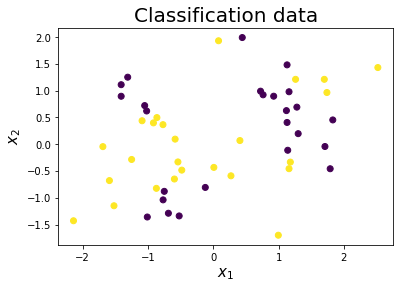

In [8]:
# Loading the data

import csv
XY = []
with open("banana.csv") as csvfile:
    reader = csv.reader(csvfile, quoting=csv.QUOTE_NONNUMERIC) # change contents to floats
    for row in reader: # each row is a list
        XY.append(row)
XY = np.array(XY)

# Here we select a subset of the data. (remember computations scales as N^3)
N = 50
X, Y = XY[:N,:-1],XY[:N,-1:]
Y = (Y-1.5) * 2 # to be in {-1, 1}
N = X.shape[0]

# Plotting the data

plt.scatter(X[:,0], X[:,1], c=Y)
plt.xlabel('$x_1$', fontsize=15)
plt.ylabel('$x_2$', fontsize=15)
plt.title('Classification data', fontsize=20);

#### Preparing prior statistics

We need to compute the prior covariance $K_p = K_{\bf ff}$ and its Cholesky factor $L_p = chol(K_{\bf ff})$.

In [9]:
# kernel parameters
l = 0.5
s = 0.5 # the standart deviation

### computing the kernel matrix K_ff

###############################################
# ------- insert code here -------------------
def create_se_kernel(X1, X2, alpha=1, scale=1):
    sqdist = tf.reshape(tf.math.reduce_sum(X1**2, axis=1),[-1,1]) + tf.reshape(tf.math.reduce_sum(X2**2, axis=1),[1,-1]) - 2*X1@tf.transpose(X2)
    return alpha * tf.math.exp(-sqdist/(2*scale**2))


K=create_se_kernel(X,X,s**2,l)
###############################################

### Computing m_p, L_p = cholesky(K_p).

###############################################
# ------- insert code here -------------------
L_p=tf.linalg.cholesky(K)
m_p=tf.zeros(N,dtype=tf.float64)
###############################################

We initialize the variational distribution to $q({\bf f})={\cal N}({\bf f};0, I)$,
then optimize the ELBO using gradient based optimization.


Gradient based optimization refers to optimization schemes where a function $f(\theta)$ is optimized with respect to $\theta$ by following the gradient $\nabla_{\theta} f(\theta)$.
For example gradient descent construct a sequence of values $\theta_t$ following
$$\theta_{t+1 } = \theta_t + \eta \nabla_{\theta} f(\theta)|_{\theta=\theta_t}$$
where $\eta$ is the learning rate.


When using an automatic differentiation framework, one does not need to manually derive the gradient (hence the 'automatic'). Such frameworks include tensorflow, jax, pytorch (pick your favorite). These are widely used to optimize the loss function of neural network models in supervised learning.

In [10]:
# initial distribution parameters m_q, L_q
m_q = tf.Variable(np.zeros((N, 1)), dtype=tf.float64)
L_q = tf.Variable(np.eye(N), dtype=tf.float64)

# Optimize the loss: a tensorflow routine is given
loss = lambda m, L: - elbo(m_p, L_p, m, L, Y)

# definition of a training step
def train(opt, m, L):
    with tf.GradientTape() as tape:
        tape.watch([m, L])
        loss_ = - elbo(m_p, L_p, m, L, Y)
    gradients = tape.gradient(loss_, [m, L])
    opt.apply_gradients(zip(gradients, [m, L]))
    return loss_

# you can change the optimizer or learning rate
opt = tf.optimizers.Adam(learning_rate=.0001) 

# running the optimization
loss_list=[]
for t in range(5000):
    loss_list.append(train(opt, m_q, L_q).numpy())
    if t % 500 == 0:
        print(t, loss(m_q, L_q))   


0 tf.Tensor(48165.86747541167, shape=(), dtype=float64)
500 tf.Tensor(29348.706713938544, shape=(), dtype=float64)
1000 tf.Tensor(19071.55432716209, shape=(), dtype=float64)
1500 tf.Tensor(12742.359291309147, shape=(), dtype=float64)
2000 tf.Tensor(8709.33913815118, shape=(), dtype=float64)
2500 tf.Tensor(6078.595022800776, shape=(), dtype=float64)
3000 tf.Tensor(4321.7508264704775, shape=(), dtype=float64)
3500 tf.Tensor(3116.443815564107, shape=(), dtype=float64)
4000 tf.Tensor(2267.7954162600436, shape=(), dtype=float64)
4500 tf.Tensor(1658.9474997489008, shape=(), dtype=float64)


* Plot the evolution of the ELBO as a function function of iterations.

* Plot the posterior process $p(f^*|x^*, {\cal D})$.

* Plot the predictive distribution $p(y^*=1|x^*)$.

* Repeat the procedure for different values of $(\sigma^2, l)$, can you see an improvement? Is the ELBO a good proxy for hyperparameter optimization in this example?

ELBO actually requires good hyperparamters. If change the hyperparameters dramatically, the performance will be degraded. Therefore, I would say ELBO is quite sensitive to the choice of hyperparameters. But with good hyperparameters, ELBO is a good proxy.

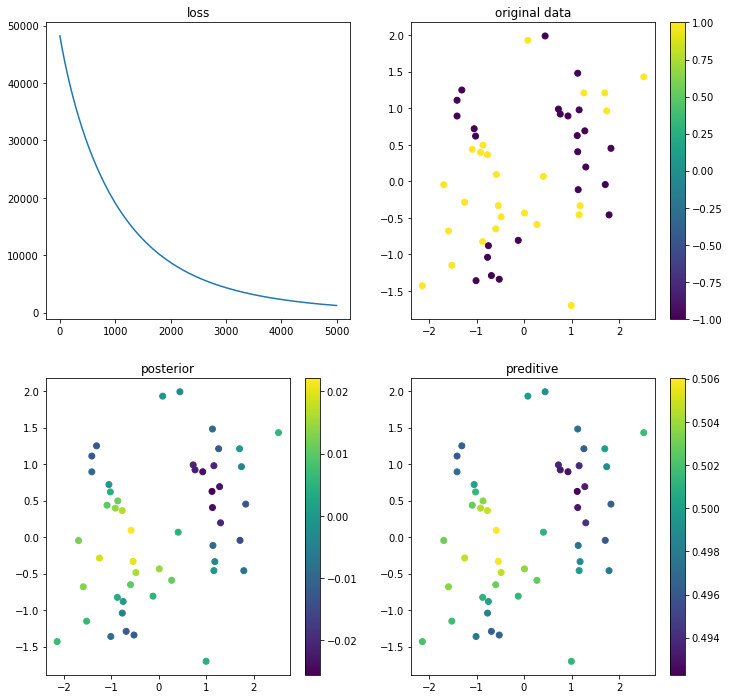

In [11]:
###############################################
# ------- insert code here -------------------
convs=L_q@tf.transpose(L_q)
var=tf.linalg.diag_part(convs)
pred_list=[]
for i in range(N):
    pred=phi(m_q[i]/tf.math.sqrt(1+var[i]))
    pred_list.append(pred)

plt.figure(figsize=(12,12))
plt.subplot(2,2,1)
plt.title('loss')
plt.plot(loss_list)

plt.subplot(2,2,2)
plt.scatter(X[:,0],X[:,1],c=Y)
plt.title('original data')
plt.colorbar()

plt.subplot(2,2,3)
plt.scatter(X[:,0],X[:,1],c=tf.squeeze(m_q))
plt.title('posterior')
plt.colorbar()

plt.subplot(2,2,4)
plt.scatter(X[:,0],X[:,1],c=tf.squeeze(pred_list))
plt.title('preditive')
plt.colorbar()
###############################################




### Task 1e: Posterior prediction for new data points

Under the hood, the algorithm defines a posterior process for all values of the input space.

For a new input $x^*$, the posterior prediction is given by 

$
\begin{align*}
q(f(x^*)) &= \int p(f(x^*)|{\bf f})q({\bf f})d{\bf f}\\
 &= {\cal N}(f(x^*)| K_{f^*{\bf f} }K_{{\bf ff}}^{-1} m_q,
 K_{f^*f^*} - K_{f^*{\bf f}}K_{{\bf ff}}^{-1}(K_{{\bf ff}} - S)K_{{\bf ff}}^{-1}K_{{\bf f} f^*})
\end{align*}
$

In [12]:
def posterior_marginal_prediction(X_new, X, m_q, L_q):
    """ compute the posterior marginal predictions q(f(x*))
    independently for all inputs in X_new 
  
    Note: You need to now use tensorflow functions

    arguments:
    X_new -- N_new x 2, matrix of new inputs
    X     -- N x 2, matrix of training inputs
    L_q   -- N x N, Cholesky factor of the covariances of q
    m_q   -- N x 1, mean vector of q
    returns: predictive marginal means and variances (both with size N_new x 1) 
    """
  

    ###############################################
    # ------- insert code here -------------------
    S=L_q@tf.transpose(L_q)

    K_ff=create_se_kernel(X,X,s**2,l)
    K_pf=create_se_kernel(X_new,X,s**2,l)
    K_fp=create_se_kernel(X,X_new,s**2,l)
    K_pp=create_se_kernel(X_new,X_new,s**2,l)
    K_ff_inv=tf.linalg.inv(K_ff)

    return K_pf@K_ff_inv@m_q,K_pp-K_pf@K_ff_inv@(K_ff-S)@K_ff_inv@K_fp

    ###############################################

    
    
    

Plotting the prediction

Text(0.5, 1.0, 'posterior preditive')

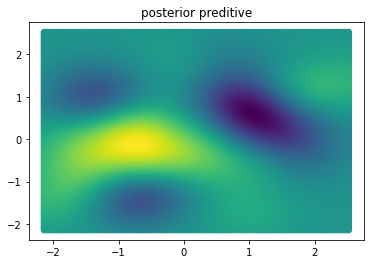

In [13]:
# create new input points on grid
n_grid = 100
x = np.linspace(X.min(), X.max(), n_grid)
X1new, X2new = np.meshgrid(x, x)
Xnew = np.hstack([
  X1new.reshape(-1,1), X2new.reshape(-1,1)
])  # size : n_grid * n_grid x 2

###############################################
# ------- insert code here -------------------

post_pred_mean,post_pred_convs=posterior_marginal_prediction(Xnew,X,m_q,L_q)

plt.scatter(Xnew[:,0],Xnew[:,1],c=tf.squeeze(post_pred_mean))
plt.title('posterior preditive')
###############################################
  

    

### Advanced [for the curious, no extra points]
* Repeat the procedure for the regression setting with Gaussian noise. You need to derive new variational expectations since the likelihood changes. Apply the resulting algorithm to the regression problem of the previous assignment.
* For fixed hyperparameters, do the ELBO match the marginal likelihood $\log p({\bf y})$? If so why?

In [ ]:
###############################################
# ------- insert code here -------------------
###############################################

# Task 2: GPLVM's (worth 1 point)

Latent variable models attempt to capture hidden structure in high dimensional
data. Given a collection of
high-dimensional observations (e.g., images), we can posit some low-dimensional
latent structure. We assume that, conditional on the latent structure, the large
number of outputs (pixels in the image) are independent of each other. Training
in this model consists of
   1. optimizing model parameters (kernel function parameters as well as, e.g.,
   observation noise variance), and
   2. finding, for each training observation (image), a corresponding point
   location in the index set.
All of the optimization can be done by maximizing the marginal log likelihood of
the data.

## Imports

For these tasks you Tensorflow, gpflow and GPy libraries. 

In [2]:
pip install tensorflow==2.4.1 gpflow==2.1.4 GPy

     |████████████████████████████████| 255 kB 8.1 MB/s eta 0:00:01
     |████████████████████████████████| 394.4 MB 23 kB/s s eta 0:00:01
     |████████████████████████████████| 3.8 MB 36.9 MB/s eta 0:00:01
     |████████████████████████████████| 462 kB 43.1 MB/s eta 0:00:01
     |████████████████████████████████| 995 kB 50.2 MB/s eta 0:00:01
     |████████████████████████████████| 71 kB 19.8 MB/s eta 0:00:01
  Created wheel for GPy: filename=GPy-1.9.9-cp38-cp38-linux_x86_64.whl size=2366231 sha256=96d72b33bddd3bc9a29b93b6962025f4d325146d971fbf796a328f5cbb513107
  Stored in directory: /home/xiaoh2/.cache/pip/wheels/6f/42/43/fd9655711b8f8517ffc104cce1b49c7e3ab7bce6a88bb2f0fb
  Created wheel for paramz: filename=paramz-0.9.5-py3-none-any.whl size=102550 sha256=fd5fbc7d79981e9aa137f1cad1eb1b3d77f3d678b518720136b0853a88e492a2
  Stored in directory: /home/xiaoh2/.cache/pip/wheels/66/78/6c/d98cb437834de5e29381786b4ba8a77ea68cca74653ab62713
Successfully built GPy paramz
  Attempting uninstal

In [1]:
import numpy as np
np.random.seed(1)  # for reproducibility
import matplotlib.pyplot as plt

import tensorflow as tf
import gpflow
from gpflow.utilities import ops, print_summary
from gpflow.config import set_default_float, default_float, set_default_summary_fmt
from gpflow.ci_utils import ci_niter

from sklearn.decomposition import PCA

%pylab inline
%matplotlib inline

set_default_float(np.float64)
set_default_summary_fmt("notebook")

Populating the interactive namespace from numpy and matplotlib


In [2]:
def load_MNIST(N=500):
    import random

    (y_train, labels_train), (_, _) = tf.keras.datasets.mnist.load_data()

    # Shuffle data and subsample
    new_idx = np.arange(y_train.shape[0])
    np.random.shuffle(new_idx)
    y_train, labels_train = y_train[new_idx, :, :], labels_train[new_idx]
    sub_y_train = y_train[:N, ...].astype(np.float64) / 256.
    labels = labels_train[:N]
    y = sub_y_train.reshape(N, -1)

    def view_MNIST():
        # Lets look at the sub sampled data
        rand_idx = np.random.randint(0, N-1)
        plt.imshow(y[rand_idx, :].reshape((28,28)), interpolation='none', cmap='Greys')
        plt.title(f'Random sample with label {labels[rand_idx]}')
        plt.show()

    view_MNIST()

    print("Number of points: {} and Number of dimensions: {}".format(y.shape[0], y.shape[1]))
    return y, labels

def load_three_phase_oil():
    data = np.load("./data/three_phase_oil_flow.npz")
    y =data["Y"]
    labels = data["labels"]
    
    print("Number of points: {} and Number of dimensions: {}".format(y.shape[0], y.shape[1]))
    return y, labels

def load_swiss_roll(N=500):
    from sklearn import datasets
    y, color = datasets.make_swiss_roll(n_samples=N)
    
    print("Number of points: {} and Number of dimensions: {}".format(y.shape[0], y.shape[1]))
    return y, color

def load_decampos_digits():
    import GPy
    which = [0,1,2,6,7,9] # which digits to work on
    data = GPy.util.datasets.decampos_digits(which_digits=which)
    y = data['Y']
    labels = data['str_lbls'].ravel()
    
    print("Number of points: {} and Number of dimensions: {}".format(y.shape[0], y.shape[1]))
    return y, labels



## (B)GPLVM model setup

In [4]:
# Shared model parameter set up
#latent_dim = 2                            # number of latent dimensions
#n_data_points = y.shape[0]                # number of data points
#n_data_dims = y.shape[1]                  # number of data dimensions

def create_GPLVM(kernel):
    
    X_init = ops.pca_reduce(y, latent_dim)              # Initialise latent
    
    # alternative initialisations...
    # X_init+= np.random.randn(X_init.shape)
    X_parameter = gpflow.base.Parameter(X_init)
    Y_tensor = gpflow.models.util.data_input_to_tensor(y)

    gplvm = gpflow.models.gpr.GPR((X_parameter, Y_tensor), kernel=kernel)
    gplvm.likelihood.variance.assign(0.01)
    
    return gplvm

def create_GPLVM_wrapped(kernel):
    # Initialise latent
    X_mean_init = ops.pca_reduce(y, latent_dim)
    
    gplvm = gpflow.models.GPLVM(
        y,
        latent_dim = latent_dim,
        X_data_mean = X_mean_init,
        kernel=kernel,
    )

    gplvm.likelihood.variance.assign(0.01)

    # Helper function
    #def get_latent(model):
    #    return 
    
    return gplvm#, get_latent

def create_BGPLVM(kernel, num_inducing=25):
    # Initialise latent
    X_mean_init = ops.pca_reduce(y, latent_dim)
    
    # Initial inducing points
    inducing_variable = tf.convert_to_tensor(
        np.random.permutation(X_mean_init.numpy())[:num_inducing], dtype=default_float()
    )
    # Initialise latent variance
    X_var_init = tf.ones((y.shape[0], latent_dim), dtype=default_float())


    gplvm = gpflow.models.BayesianGPLVM(
        y,
        X_data_mean=X_mean_init,
        X_data_var=X_var_init,
        kernel=kernel,
        inducing_variable=inducing_variable,
    )

    gplvm.likelihood.variance.assign(0.01)
    
    return gplvm

get_latent_mean = lambda model: model.X_data_mean.numpy()
get_latent = lambda model: model.data[0].numpy()


## GPLVM and comparison to PCA

warning in stationary: failed to import cython module: falling back to numpy
warning in choleskies: failed to import cython module: falling back to numpy
Acquiring resource: decampos_characters

Details of data: 
Examples of hand written digits taken from the de Campos et al paper on Character Recognition in Natural Images.

Please cite:
T. de Campos, B. R. Babu, and M. Varma. Character recognition in natural images. VISAPP 2009.

After downloading the data will take up 2031872 bytes of space.

Data will be stored in /home/xiaoh2/tmp/GPy-datasets/decampos_characters.

Do you wish to proceed with the download? [yes/no]


 yes


characters.npy
[==============================]   5.586/5.586MB                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

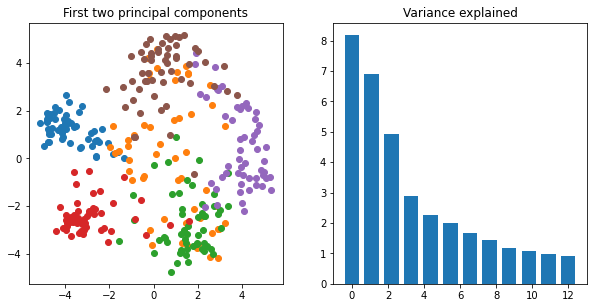

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,"(4,)",float64,"[4.04457620e-05, 3.07968540e-04, 5.90229690e-04..."
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.1212632374962167
GPR.data[0],Parameter,Identity,,True,"(330, 4)",float64,"[[2.84041636, 12.00960237, 26.23789191..."


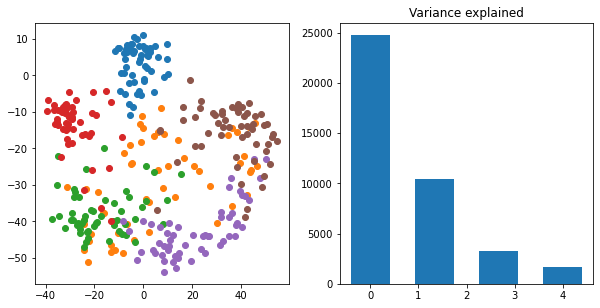

In [5]:
y, labels = load_decampos_digits()

# PCA
pca_latent = 12
pca = PCA(n_components=pca_latent)
X_pca = pca.fit_transform(y-y.mean())
f, ax = plt.subplots(1, 2, figsize=(10, 4.8))
ax[0].set_title('First two principal components')
for i in np.unique(labels):
    ax[0].scatter(X_pca[labels == i, 0], X_pca[labels == i, 1], label=i)
ax[1].bar(np.linspace(0, pca_latent, pca_latent), pca.explained_variance_)
ax[1].set_title('Variance explained');
plt.show()

# GPLVM with linear kernel
latent_dim = 4
lengthscales = tf.convert_to_tensor([1.] * latent_dim, dtype=default_float())
kernel = gpflow.kernels.Linear(variance=lengthscales)  
gplvm = create_GPLVM(kernel)
opt = gpflow.optimizers.Scipy()                       
maxiter = ci_niter(10000)
_ = opt.minimize(
    gplvm.training_loss,
    method="BFGS",
    variables=gplvm.trainable_variables,
    options=dict(maxiter=maxiter),
)     
print_summary(gplvm)
order = gplvm.kernel.variance.numpy().argsort()
f, ax = plt.subplots(1, 2, figsize=(10, 4.8))
X_gplvm_linear = gplvm.data[0].numpy()[:, order]
for i in np.unique(labels):
    ax[0].scatter(X_gplvm_linear[labels == i, 0], X_gplvm_linear[labels == i, 1], label=i)
#ax[0].scatter(X_gplvm_linear[:, 0], X_gplvm_linear[:, 1], c=labels)
ax[1].bar(np.linspace(0, latent_dim, latent_dim), 1/gplvm.kernel.variance.numpy()[order])
ax[1].set_title('Variance explained');


## Task 2a

How does your linear solution differ between PCA and GPLVM with a linear kernel? Look at the plots and also try and consider how the linear ARD parameters compare to the eigenvalues of the principal components.


__Solution__

From the scatter plots on the left, if we compare them in a rotated version, they are almost the same thing. On the right, it basically tells us how much variance the components explain. Obviously, the GPLVM works better because it used fewer components but captured most variance in the data. The sixth and later components in PCA method share similar variance that account for a big variance in data, which is bad in feature reduction. We always hope use fewer components to caputer variance as many as possible. Therefore, I would say GPLVM performs better than PCA in this data.


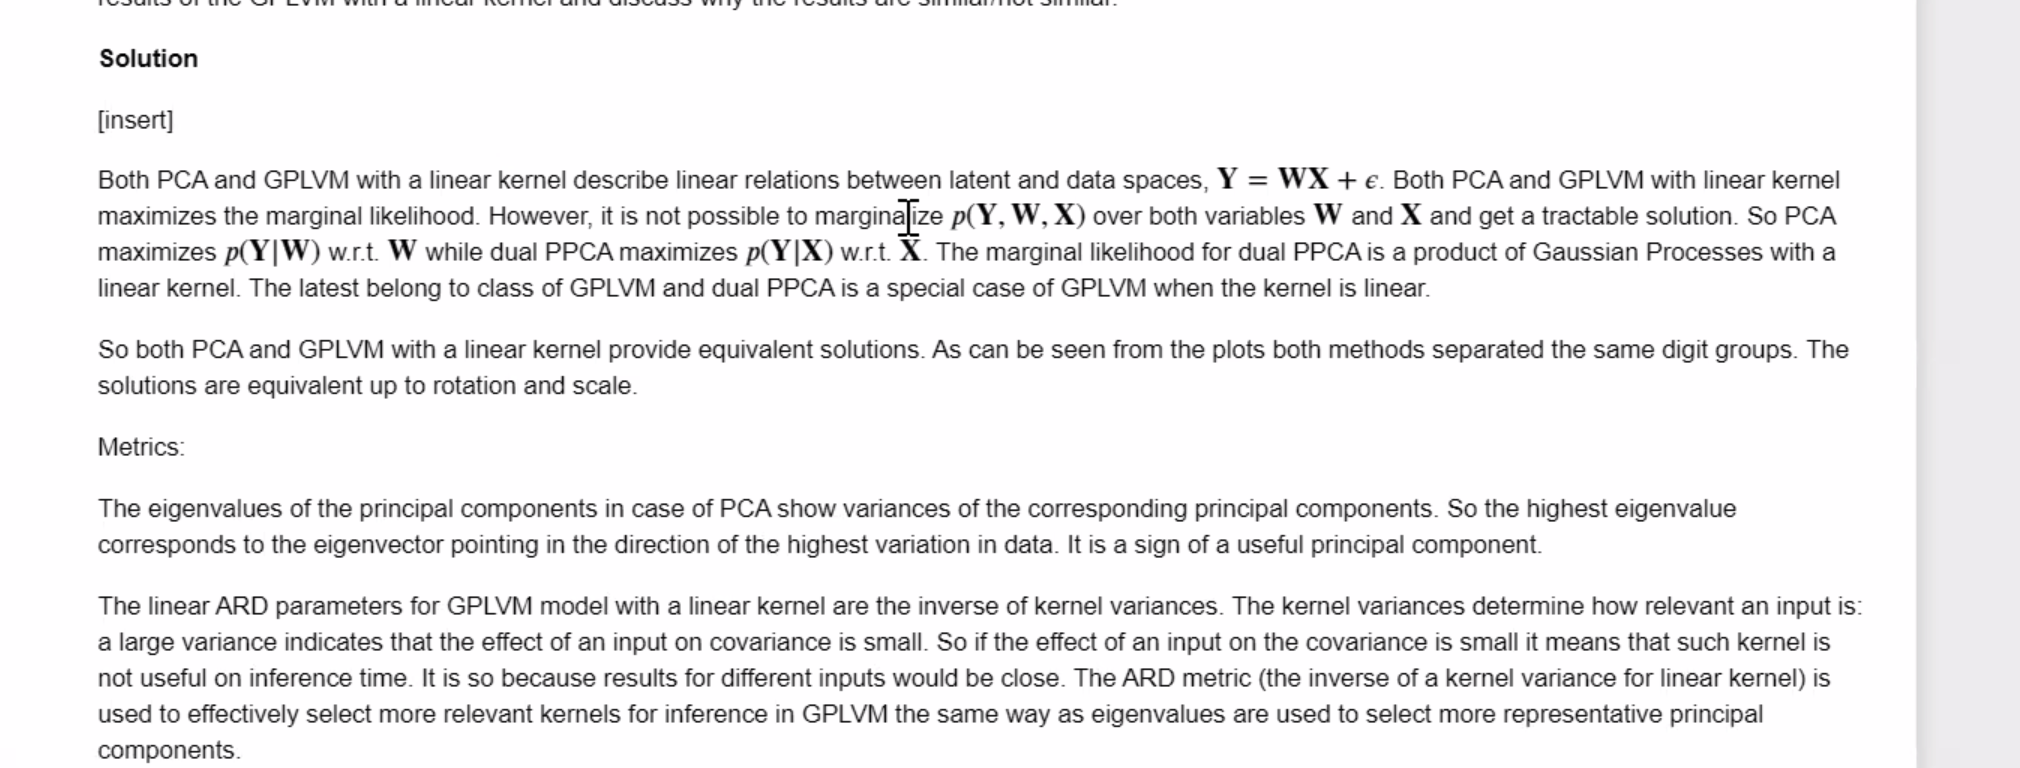

## Task 2b

Change the initialisation of the latent variables X_init inside the GPLVM model builder function. How this does change the results?

Hint: Try random noise, or a subset of the dimensions.

__Solution__

Adding random noise and reduction of dimensions degrade the performance. The reason is quite straight-forward that we reduce the information entropy(hide some information in two different ways).

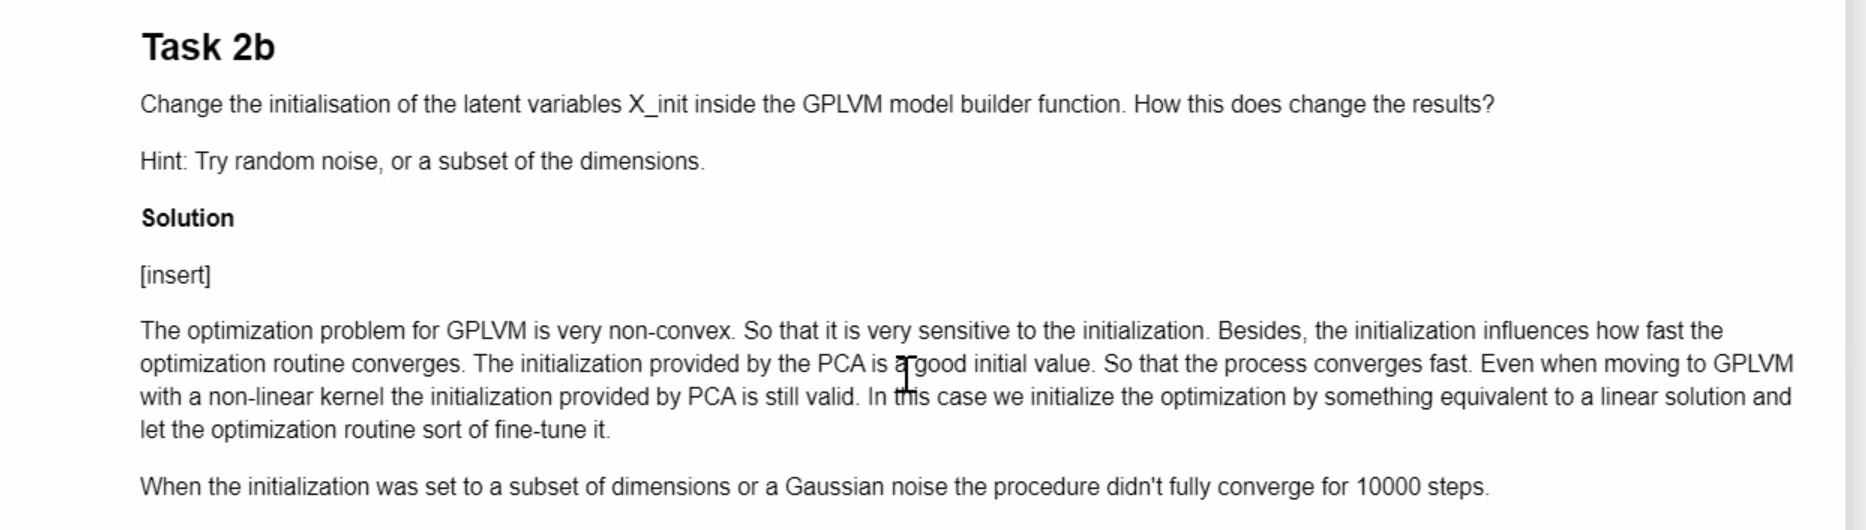

## Task 2c

The next step is to use a non-linear mapping between latent variables  __$X$__  and features  __$Y$__  by selecting the exponentiated quadratic covariance function. Run the code below.

How does choosing a non-linear kernel affect the results? Are there digits that the GPLVM with an exponentiated quadratic covariance can separate, which PCA is not able to?

__Solution__

Using a non-linear kernel dramatically improves the performance. The first two components account for more variance compared to the former two methods. As we can see in the left plot, the digit 0 has been well separated since a clear gap exists against other clusters.

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,0.3302229914640213
GPR.kernel.lengthscales,Parameter,Softplus,,True,"(4,)",float64,"[0.48947352, 0.54172518, 6.20407059..."
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.0408216131168088
GPR.data[0],Parameter,Identity,,True,"(330, 4)",float64,"[[-0.41799089, -0.70920039, -2.45240664..."


<BarContainer object of 4 artists>

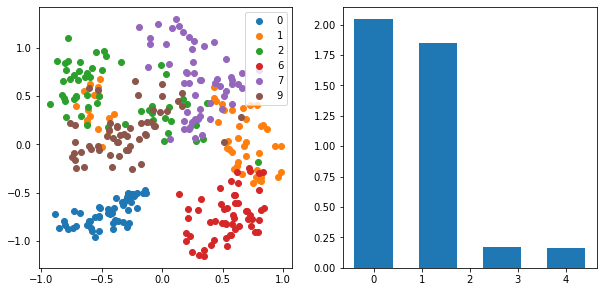

In [15]:
lengthscales = tf.convert_to_tensor([1.] * latent_dim, dtype=default_float())
kernel = gpflow.kernels.RBF(lengthscales=lengthscales)
gplvm = create_GPLVM(kernel)

opt = gpflow.optimizers.Scipy()                       
maxiter = ci_niter(1000)
_ = opt.minimize(
    gplvm.training_loss,
    method="BFGS",
    variables=gplvm.trainable_variables,
    options=dict(maxiter=maxiter),
)     
print_summary(gplvm)

order = (gplvm.kernel.lengthscales.numpy()).argsort()
f, ax = plt.subplots(1, 2, figsize=(10, 4.8))
X_gplvm_rbf = gplvm.data[0].numpy()[:, order]
for i in np.unique(labels):
    ax[0].scatter(X_gplvm_rbf[labels == i, 0], X_gplvm_rbf[labels == i, 1], label=i)
ax[0].legend()
ax[1].bar(np.linspace(0, latent_dim, latent_dim), 1/gplvm.kernel.lengthscales.numpy()[order])


## Bayesian GPLVM

GPLVM needs not make anyassumptions on the prior of latent variables. However, lack of such assumption makes the model inferred by just maximizingthe log marginal likelihood prone to overfitting. To tackle this problem, one of effective approaches is to impose a specific prior onto the latent variables for a posterior estimation. Thus, we can introduce various constraints into the prior for the estimation the latent variables in different tasks. Specifically, we assume that $p(X)$ denotes the imposed prior. By using the Bayesian theorem, we can formulate the posterior probability of the latent variables X as $p(X|Y,\theta) \propto p(Y|X,\theta)p(X)$ 



In [ ]:
lengthscales = tf.convert_to_tensor([1.] * latent_dim, dtype=default_float())
kernel = gpflow.kernels.RBF(lengthscales=lengthscales)
bgplvm = create_BGPLVM(kernel, num_inducing=20)

# This will take minutes to run.
# You can interrupt the kernel
opt = gpflow.optimizers.Scipy()                       
maxiter = ci_niter(1000)
_ = opt.minimize(
    bgplvm.training_loss,
    method="BFGS",
    variables=bgplvm.trainable_variables,
    options=dict(maxiter=maxiter),
)     
print_summary(bgplvm)

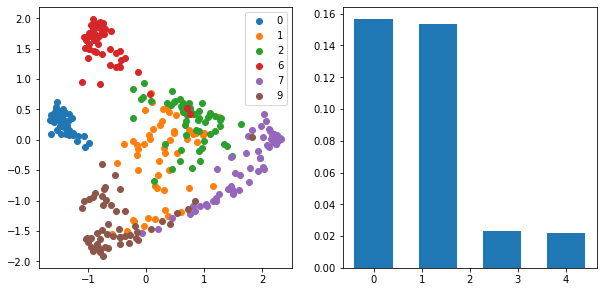

In [7]:
order = (bgplvm.kernel.lengthscales.numpy()).argsort()
f, ax = plt.subplots(1, 2, figsize=(10, 4.8))
X_bgplvm_rbf = bgplvm.X_data_mean.numpy()[:, order]
for i in np.unique(labels):
    ax[0].scatter(X_bgplvm_rbf[labels == i, 0], X_bgplvm_rbf[labels == i, 1], label=i)
ax[0].legend()
ax[1].bar(np.linspace(0, latent_dim, latent_dim), 1/bgplvm.kernel.lengthscales.numpy()[order]);


## Task 2d 

* How does the Bayesian GP-LVM compare with the GPLVM model?  
* How has the prior on $X$ affected the results?
* Are there any classes that still overlap? Why?

__Solution__

* The data separation looks even better. The digits '6','7','0', '9' are well-separated.
* The prior X can further improve feature reduction, more variance is captured.
* I didn't wait for the training process to end. But I suppose there are still some classes still overlap. For the reason, I would say they are actually quite close in the hyper space, if we cannot provide an informative prior, it would be hard to sperate them out.

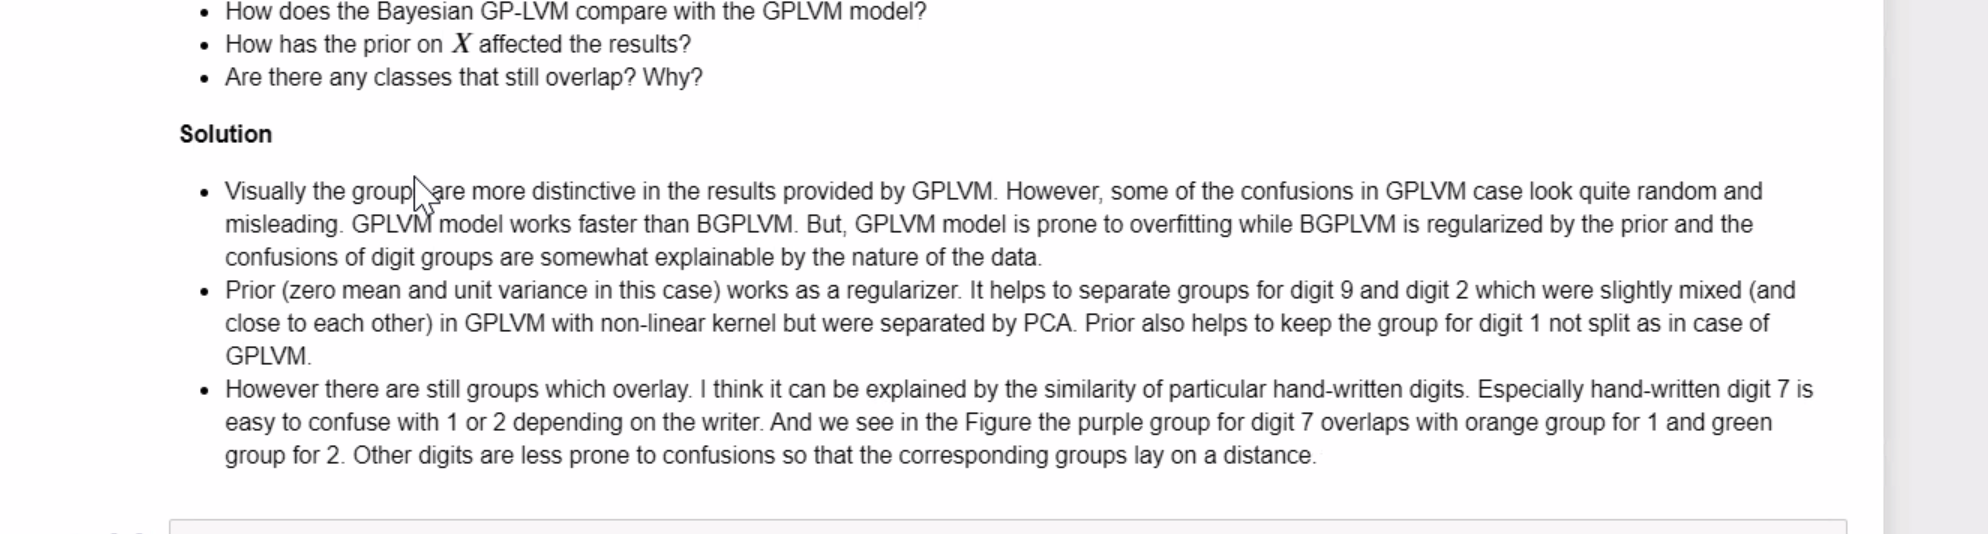